# 🔗 Link Prediction with GraphSAGE on Cora Dataset

This notebook performs link prediction on the Cora citation network using a Graph Neural Network (GraphSAGE).

In [1]:
# 📦 Install required libraries
!pip install torch torchvision torchaudio torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
# 📚 Import packages
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import train_test_split_edges, negative_sampling
from sklearn.metrics import roc_auc_score
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# 🔄 Load and split data
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
data = train_test_split_edges(data)

Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [4]:
# 🧠 Define the GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

In [5]:
# 🚂 Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(dataset.num_node_features, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)

    neg_edge_index = negative_sampling(
        edge_index=train_pos_edge_index,
        num_nodes=z.size(0)
    )

    pos_score = model.decode(z, train_pos_edge_index)
    neg_score = model.decode(z, neg_edge_index)

    pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean()
    neg_loss = -torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()
    loss = pos_loss + neg_loss
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 10, Loss: 1.4298
Epoch 20, Loss: 1.4045
Epoch 30, Loss: 1.3923
Epoch 40, Loss: 1.3885
Epoch 50, Loss: 1.3873
Epoch 60, Loss: 1.3869
Epoch 70, Loss: 1.3867
Epoch 80, Loss: 1.3866
Epoch 90, Loss: 1.3865
Epoch 100, Loss: 1.3864


In [6]:
# 🧪 Evaluate model with AUC
model.eval()
with torch.no_grad():
    z = model.encode(x, train_pos_edge_index)
    pos_edge_index = data.test_pos_edge_index.to(device)
    neg_edge_index = data.test_neg_edge_index.to(device)

    pos_score = torch.sigmoid(model.decode(z, pos_edge_index)).cpu()
    neg_score = torch.sigmoid(model.decode(z, neg_edge_index)).cpu()

    y_true = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])
    y_score = torch.cat([pos_score, neg_score])

    auc = roc_auc_score(y_true, y_score)
    print(f'Test AUC: {auc:.4f}')

Test AUC: 0.5000


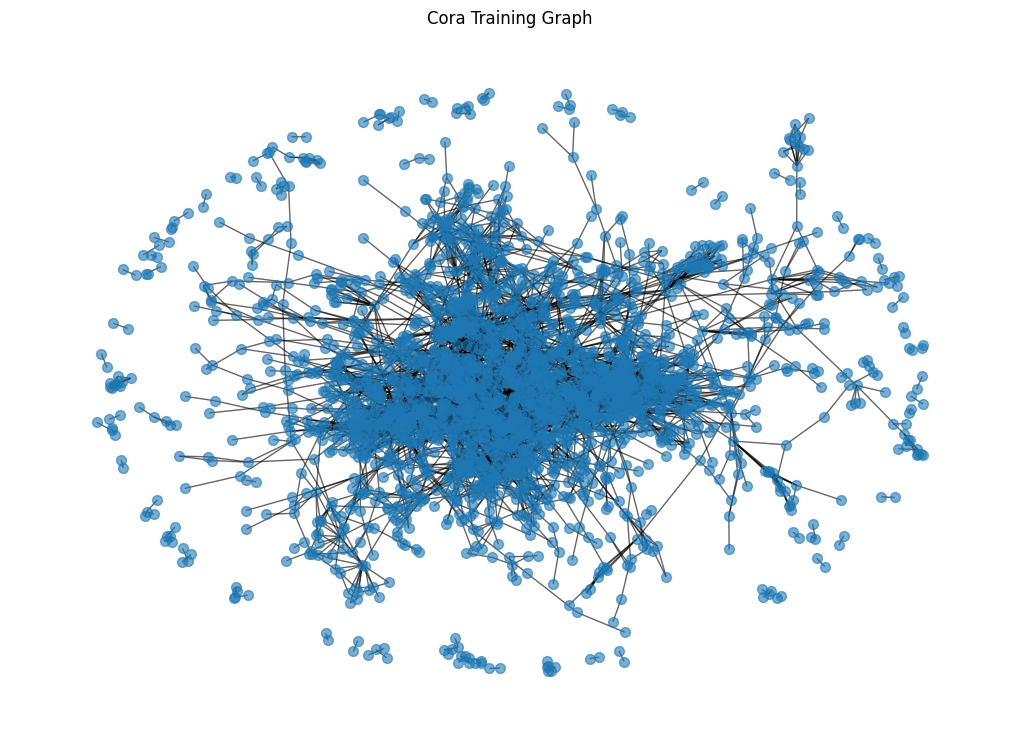

In [7]:
# 🔍 Visualize predicted links
G = nx.Graph()
G.add_edges_from(data.train_pos_edge_index.cpu().numpy().T)
plt.figure(figsize=(10, 7))
nx.draw(G, node_size=50, alpha=0.6)
plt.title("Cora Training Graph")
plt.show()

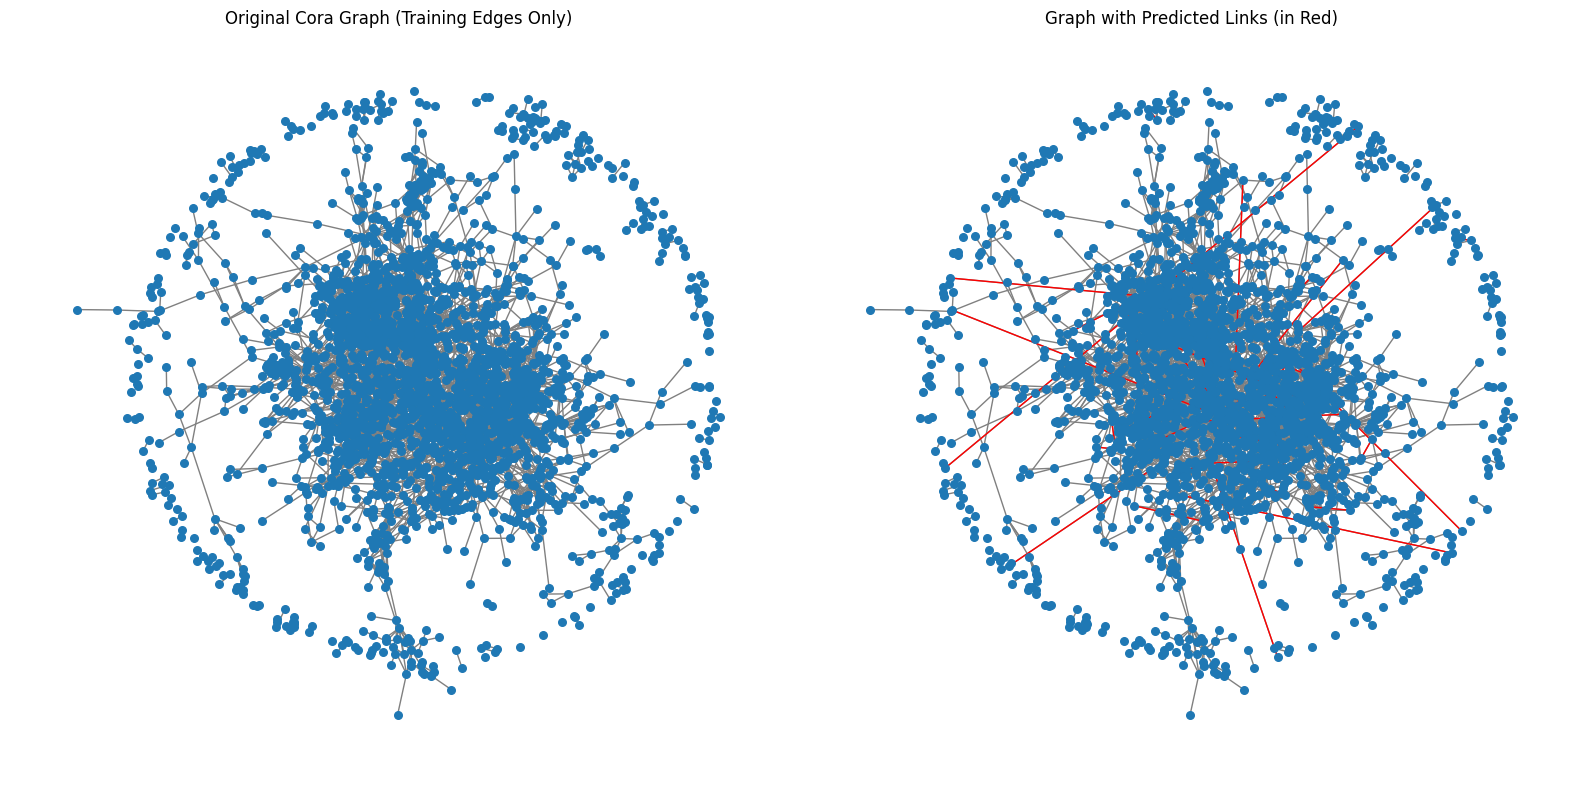

In [9]:
# 📊 Compare Original vs Predicted Links
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data # Import Data class

# Convert original training graph
# Create a new Data object with the original nodes and the training edges
train_data_for_viz = Data(x=data.x, edge_index=data.train_pos_edge_index)

# Convert this new Data object to networkx
G_original = to_networkx(train_data_for_viz, to_undirected=True)

# Simulated predicted links (first 50 test edges for illustration)
# Ensure predicted_edges contains actual edges, not just indices
# If you want to visualize predicted links, these should be edges predicted by your model, not just a subset of test edges.
# For the purpose of visualization as requested, using test_pos_edge_index is an illustration.
predicted_edges = data.test_pos_edge_index[:, :50].t().tolist()

# Graph with predicted links
G_predicted = G_original.copy()
# Add predicted edges to the graph. Networkx handles duplicate edges gracefully.
G_predicted.add_edges_from(predicted_edges)

# Shared layout - Use layout based on the graph with training edges for consistency
pos = nx.spring_layout(G_original, seed=42)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
nx.draw(G_original, pos=pos, ax=axes[0], node_size=30, edge_color="gray")
axes[0].set_title("Original Cora Graph (Training Edges Only)")

# Redraw G_predicted using the same layout
nx.draw(G_predicted, pos=pos, ax=axes[1], node_size=30, edge_color="gray")
# Draw the predicted edges specifically in red on the G_predicted graph
nx.draw_networkx_edges(G_predicted, pos=pos, edgelist=predicted_edges, edge_color="red", ax=axes[1])
axes[1].set_title("Graph with Predicted Links (in Red)")
plt.tight_layout()
plt.show()